In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
import numpy as np
import pandas as pd

from sklearn import decomposition, random_projection
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.neighbors import KNeighborsClassifier

import enrichr
import evaluations

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('talk')

In [3]:
import h5py

In [4]:
file = h5py.File('../data/archs4/human_matrix.h5', 'r')
list(file.keys())

['info', 'data', 'meta']

In [5]:
genes_archs4 = file['meta']['genes'][:].astype(np.str)
genes_archs4[:10]

array(['A1BG', 'A1CF', 'A2M', 'A2ML1', 'A2MP1', 'A3GALT2', 'A4GALT',
       'A4GNT', 'AAAS', 'AACS'], dtype='<U20')

In [6]:
genes_archs4.shape

(35238,)

In [7]:
len(set(genes_archs4))

35238

In [8]:
file['data']['expression'].shape

(133776, 35238)

In [9]:
# Retrieve matrix from h5 file
mat = file['data']['expression'][:10000]
print(type(mat), mat.dtype)

<class 'numpy.ndarray'> int32


In [10]:
# TF-IDF normalization, replace tf with 1 + log(tf).
tfidf = TfidfTransformer(norm='l2', sublinear_tf=True)
tfidf_mat = tfidf.fit_transform(mat)
tfidf_mat.shape

(10000, 35238)

In [11]:
# TF-IDF normalization
tfidf = TfidfTransformer(norm='l2', sublinear_tf=False)
tfidf_mat2 = tfidf.fit_transform(mat)
tfidf_mat2.shape

(10000, 35238)

In [12]:
n_topics = 100

In [13]:
grp = random_projection.GaussianRandomProjection(n_components=n_topics, 
                                                 random_state=2018)
grp.fit(tfidf_mat)
grp_mat_df = pd.DataFrame(grp.components_.T, index=genes_archs4) # genes by topics matrix
print(grp_mat_df.shape)

(35238, 100)


In [14]:
grp2 = random_projection.GaussianRandomProjection(n_components=n_topics, 
                                                 random_state=2018)
grp2.fit(tfidf_mat2)
grp_mat_df2 = pd.DataFrame(grp2.components_.T, index=genes_archs4) # genes by topics matrix
print(grp_mat_df2.shape)

(35238, 100)


In [15]:
srp = random_projection.SparseRandomProjection(n_components=n_topics,
                                               density='auto',
                                               random_state=2018
                                              )
srp.fit(tfidf_mat)
print('density:', srp.density_)
srp_mat_df = pd.DataFrame(srp.components_.toarray().T, index=genes_archs4) # genes by topics matrix
print(srp_mat_df.shape)

density: 0.005327143237881408
(35238, 100)


In [16]:
srp2 = random_projection.SparseRandomProjection(n_components=n_topics,
                                               density='auto',
                                               random_state=2018
                                              )
srp2.fit(tfidf_mat2)
print('density:', srp2.density_)
srp_mat_df2 = pd.DataFrame(srp2.components_.toarray().T, index=genes_archs4) # genes by topics matrix
print(srp_mat_df2.shape)

density: 0.005327143237881408
(35238, 100)


In [17]:
from joblib import load, dump

In [18]:
# svd = decomposition.TruncatedSVD(n_components=n_topics,
#                                 random_state=2018)
# svd.fit(tfidf_mat)
# X_topics_svd = pd.DataFrame(svd.components_.T, index=genes_archs4) # genes by topics matrix
# print(X_topics_svd.shape)
svd = load('../data/models/SVD-on_archs4.joblib')
X_topics_svd = pd.DataFrame(svd.components_.T, index=genes_archs4) # genes by topics matrix
print(X_topics_svd.shape)

(35238, 100)


In [19]:
svd2 = decomposition.TruncatedSVD(n_components=n_topics,
                                random_state=2018)
svd2.fit(tfidf_mat2)
X_topics_svd2 = pd.DataFrame(svd2.components_.T, index=genes_archs4) # genes by topics matrix
print(X_topics_svd2.shape)

(35238, 100)


# Evaluate

In [20]:
# libs used for evaluation
libs_y = ['KEGG_2016', 
          'GO_Molecular_Function_2018',
          'ENCODE_Histone_Modifications_2015']

# Parse all gmts 
d_gmt = {}
for lib_name in libs_y:
    fp = enrichr.get_library_filepath(lib_name)
    d_gmt_i = enrichr.parse_gmt(fp, namespace=lib_name)
    d_gmt.update(d_gmt_i)

print('Number of gene sets:', len(d_gmt))

Number of gene sets: 1856


In [21]:
# term-frequency matrix (gene sets x genes)
tf_mat, genes_enrichr = enrichr.gmt2mat(d_gmt, sparse_output=True, min_frequency=0)
tf_mat.shape

(1856, 29913)

In [22]:
tf_mat_df = pd.DataFrame(tf_mat.transpose().toarray(), index=genes_enrichr)
tf_mat_df.shape

(29913, 1856)

In [23]:
# Create a df for terms in gmt
terms_df = pd.DataFrame({
    'library': [ s.split('$')[0] for s in d_gmt.keys()],
    'term': [ s.split('$')[1] for s in d_gmt.keys()],
    'n_genes': [len(val) for val in d_gmt.values()]
}, index=list(d_gmt.keys()))
print(terms_df.shape)

(1856, 3)


In [24]:
# Find shared genes between ARCHS4 and Enrichr
shared_genes = list(set(tf_mat_df.index) & set(genes_archs4))
len(shared_genes)

19133

In [50]:
tf_mat_df = tf_mat_df.loc[shared_genes]

grp_mat_df = grp_mat_df.loc[shared_genes]
grp_mat_df2 = grp_mat_df2.loc[shared_genes]

srp_mat_df = srp_mat_df.loc[shared_genes]
srp_mat_df2 = srp_mat_df2.loc[shared_genes]

print(tf_mat_df.shape, srp_mat_df.shape)

(19133, 1856) (19133, 100)


In [26]:
X_topics_svd = X_topics_svd.loc[shared_genes]
X_topics_svd2 = X_topics_svd2.loc[shared_genes]


In [27]:
knn_scores = evaluations.NN_generalization_accuracy_wrapper(srp_mat_df.values, libs_y, 
                                                tf_mat_df.values, 
                                                terms_df['library'],
                                               dummy=True, 
                                               model_name='baseline')

KEGG_2016 (19133, 293)
GO_Molecular_Function_2018 (19133, 1151)
ENCODE_Histone_Modifications_2015 (19133, 412)


In [28]:
knn_scores_grp = evaluations.NN_generalization_accuracy_wrapper(grp_mat_df.values, libs_y, 
                                                tf_mat_df.values, 
                                                terms_df['library'],
                                               dummy=False, 
                                               model_name='GaussianRandomProjection-TFIDF-sublinear')

KEGG_2016 (19133, 293)
GO_Molecular_Function_2018 (19133, 1151)
ENCODE_Histone_Modifications_2015 (19133, 412)


In [29]:
knn_scores_grp2 = evaluations.NN_generalization_accuracy_wrapper(grp_mat_df2.values, libs_y, 
                                                tf_mat_df.values, 
                                                terms_df['library'],
                                               dummy=False, 
                                               model_name='GaussianRandomProjection-TFIDF')

KEGG_2016 (19133, 293)
GO_Molecular_Function_2018 (19133, 1151)
ENCODE_Histone_Modifications_2015 (19133, 412)


In [51]:
knn_scores_srp = evaluations.NN_generalization_accuracy_wrapper(srp_mat_df.values, libs_y, 
                                                tf_mat_df.values, 
                                                terms_df['library'],
                                               dummy=False, 
                                               model_name='SparseRandomProjection-sublinear')

KEGG_2016 (19133, 293)
GO_Molecular_Function_2018 (19133, 1151)
ENCODE_Histone_Modifications_2015 (19133, 412)


In [52]:
knn_scores_srp2 = evaluations.NN_generalization_accuracy_wrapper(srp_mat_df2.values, libs_y, 
                                                tf_mat_df.values, 
                                                terms_df['library'],
                                               dummy=False, 
                                               model_name='SparseRandomProjection-TFIDF')

KEGG_2016 (19133, 293)
GO_Molecular_Function_2018 (19133, 1151)
ENCODE_Histone_Modifications_2015 (19133, 412)


In [32]:
knn_scores_svd = evaluations.NN_generalization_accuracy_wrapper(X_topics_svd.values, libs_y, 
                                                tf_mat_df.values, 
                                                terms_df['library'],
                                               dummy=False, 
                                               model_name='SVD-TFIDF-sublinear')

KEGG_2016 (19133, 293)
GO_Molecular_Function_2018 (19133, 1151)
ENCODE_Histone_Modifications_2015 (19133, 412)


In [33]:
knn_scores_svd2 = evaluations.NN_generalization_accuracy_wrapper(X_topics_svd2.values, libs_y, 
                                                tf_mat_df.values, 
                                                terms_df['library'],
                                               dummy=False, 
                                               model_name='SVD-TFIDF')

KEGG_2016 (19133, 293)
GO_Molecular_Function_2018 (19133, 1151)
ENCODE_Histone_Modifications_2015 (19133, 412)


In [53]:
knn_scores_all = pd.concat([knn_scores, 
                            knn_scores_grp, knn_scores_grp2,
                            knn_scores_srp, knn_scores_srp2,
                            knn_scores_svd, knn_scores_svd2
                           ])
knn_scores_all.shape

(105, 3)

/Users/maayanlab/Documents/Zichen_Projects/venv3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


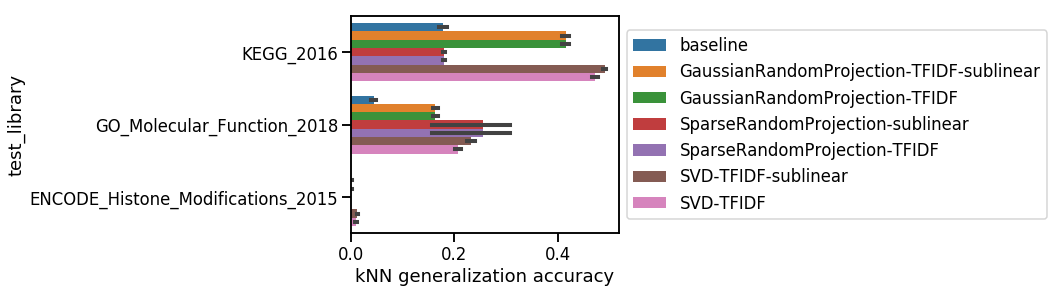

In [54]:
ax = sns.barplot(y='test_library', x='accuracy', data=knn_scores_all, hue='model')
# ax = sns.swarmplot(y='test_library', x='accuracy', data=knn_scores_all, hue='model')
ax.set_xlabel('kNN generalization accuracy')
# ax.set_xlim([-0.05, 1]);

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

In [45]:
nmf = decomposition.NMF(n_components=n_topics, 
                        alpha=.1, 
                        l1_ratio=.5,
                        random_state=2018,
                        verbose=True
                       )
nmf.fit(tfidf_mat)
X_topics_nmf = pd.DataFrame(nmf.components_.T, index=genes_archs4) # genes by topics matrix
print(X_topics_nmf.shape)

violation: 1.0
violation: 0.2174073702702259
violation: 0.05952618473460228
violation: 0.03771925559207945
violation: 0.030058020173278046
violation: 0.02588978811337069
violation: 0.02240929051127788
violation: 0.020089644640277775
violation: 0.018368466062761556
violation: 0.017073792145759194
violation: 0.01601274086644387
violation: 0.015029967180495894
violation: 0.014045716400928722
violation: 0.013042247539547714
violation: 0.01203188203736545
violation: 0.011078113953255711
violation: 0.010200978856660676
violation: 0.009426379273665365
violation: 0.008780835052815966
violation: 0.008254834651544743
violation: 0.007812840913272653
violation: 0.0074336860698627815
violation: 0.00709989086697514
violation: 0.0068009851909434
violation: 0.006529379408899288
violation: 0.006280168836360059
violation: 0.006050003881863267
violation: 0.005836228079370224
violation: 0.00563722419765296
violation: 0.00545145872015302
violation: 0.005277569557002531
violation: 0.005114510790504878
viola

In [37]:
nmf = load('../data/models/NMF-on-archs4.joblib')
X_topics_nmf = pd.DataFrame(nmf.components_.T, index=genes_archs4) # genes by topics matrix
print(X_topics_nmf.shape)

(35238, 100)


In [46]:
lda = decomposition.LatentDirichletAllocation(n_components=n_topics, 
                                              random_state=2018,
                                              verbose=10,
                                              n_jobs=10
                                             )
lda.fit(mat)


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed: 23.8min remaining: 55.5min
[Parallel(n_jobs=10)]: Done   5 out of  10 | elapsed: 24.0min remaining: 24.0min
[Parallel(n_jobs=10)]: Done   7 out of  10 | elapsed: 25.0min remaining: 10.7min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed: 25.1min finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


iteration: 1 of max_iter: 10


[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed: 23.8min remaining: 55.6min
[Parallel(n_jobs=10)]: Done   5 out of  10 | elapsed: 24.0min remaining: 24.0min
[Parallel(n_jobs=10)]: Done   7 out of  10 | elapsed: 24.9min remaining: 10.7min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed: 25.0min finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


iteration: 2 of max_iter: 10


[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed: 23.7min remaining: 55.2min
[Parallel(n_jobs=10)]: Done   5 out of  10 | elapsed: 23.9min remaining: 23.9min
[Parallel(n_jobs=10)]: Done   7 out of  10 | elapsed: 24.9min remaining: 10.7min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed: 25.0min finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


iteration: 3 of max_iter: 10


[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed: 23.7min remaining: 55.4min
[Parallel(n_jobs=10)]: Done   5 out of  10 | elapsed: 23.9min remaining: 23.9min
[Parallel(n_jobs=10)]: Done   7 out of  10 | elapsed: 24.9min remaining: 10.7min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed: 24.9min finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


iteration: 4 of max_iter: 10


[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed: 24.7min remaining: 57.6min
[Parallel(n_jobs=10)]: Done   5 out of  10 | elapsed: 24.9min remaining: 24.9min
[Parallel(n_jobs=10)]: Done   7 out of  10 | elapsed: 25.7min remaining: 11.0min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed: 25.9min finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


iteration: 5 of max_iter: 10


[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed: 24.0min remaining: 56.1min
[Parallel(n_jobs=10)]: Done   5 out of  10 | elapsed: 24.3min remaining: 24.3min
[Parallel(n_jobs=10)]: Done   7 out of  10 | elapsed: 25.2min remaining: 10.8min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed: 25.3min finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


iteration: 6 of max_iter: 10


[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed: 23.5min remaining: 54.7min
[Parallel(n_jobs=10)]: Done   5 out of  10 | elapsed: 23.7min remaining: 23.7min
[Parallel(n_jobs=10)]: Done   7 out of  10 | elapsed: 24.7min remaining: 10.6min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed: 24.8min finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


iteration: 7 of max_iter: 10


[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed: 23.9min remaining: 55.7min
[Parallel(n_jobs=10)]: Done   5 out of  10 | elapsed: 24.0min remaining: 24.0min
[Parallel(n_jobs=10)]: Done   7 out of  10 | elapsed: 25.0min remaining: 10.7min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed: 25.1min finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


iteration: 8 of max_iter: 10


[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed: 23.3min remaining: 54.3min
[Parallel(n_jobs=10)]: Done   5 out of  10 | elapsed: 23.5min remaining: 23.5min
[Parallel(n_jobs=10)]: Done   7 out of  10 | elapsed: 24.5min remaining: 10.5min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed: 24.5min finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


iteration: 9 of max_iter: 10


[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed: 23.3min remaining: 54.4min
[Parallel(n_jobs=10)]: Done   5 out of  10 | elapsed: 23.5min remaining: 23.5min
[Parallel(n_jobs=10)]: Done   7 out of  10 | elapsed: 24.5min remaining: 10.5min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed: 24.6min finished


iteration: 10 of max_iter: 10


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed: 22.3min remaining: 52.0min
[Parallel(n_jobs=10)]: Done   5 out of  10 | elapsed: 22.4min remaining: 22.4min
[Parallel(n_jobs=10)]: Done   7 out of  10 | elapsed: 23.2min remaining:  9.9min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed: 23.2min finished


NameError: name 'gene_archs4' is not defined

In [38]:
lda = load('../data/models/LDA-on-archs4.joblib')
X_topics_lda = pd.DataFrame(lda.components_.T, index=genes_archs4) # genes by topics matrix
print(X_topics_lda.shape)

(35238, 100)


In [49]:
# # Save trained models
# from joblib import dump, load
# dump(lda, '../data/models/LDA-on-archs4.joblib')

['../data/models/LDA-on-archs4.joblib']

In [50]:
# dump(nmf, '../data/models/NMF-on-archs4.joblib')

['../data/models/NMF-on-archs4.joblib']

In [51]:
# dump(svd, '../data/models/SVD-on_archs4.joblib')

['../data/models/SVD-on_archs4.joblib']

In [39]:
X_topics_lda = X_topics_lda.loc[shared_genes]
X_topics_nmf = X_topics_nmf.loc[shared_genes]

In [40]:
knn_scores_lda = evaluations.NN_generalization_accuracy_wrapper(X_topics_lda.values, libs_y, 
                                                tf_mat_df.values, 
                                                terms_df['library'],
                                               dummy=False, 
                                               model_name='LDA-TF')

KEGG_2016 (19133, 293)
GO_Molecular_Function_2018 (19133, 1151)
ENCODE_Histone_Modifications_2015 (19133, 412)


In [41]:
knn_scores_nmf = evaluations.NN_generalization_accuracy_wrapper(X_topics_nmf.values, libs_y, 
                                                tf_mat_df.values, 
                                                terms_df['library'],
                                               dummy=False, 
                                               model_name='NMF-TFIDF-sublinear')

KEGG_2016 (19133, 293)
GO_Molecular_Function_2018 (19133, 1151)
ENCODE_Histone_Modifications_2015 (19133, 412)


In [42]:
knn_scores_all = pd.concat([knn_scores, 
                            knn_scores_grp, 
                            knn_scores_srp, 
                            knn_scores_svd, 
                            knn_scores_nmf,
                            knn_scores_lda,
                           ])
knn_scores_all.shape

(90, 3)

/Users/maayanlab/Documents/Zichen_Projects/venv3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


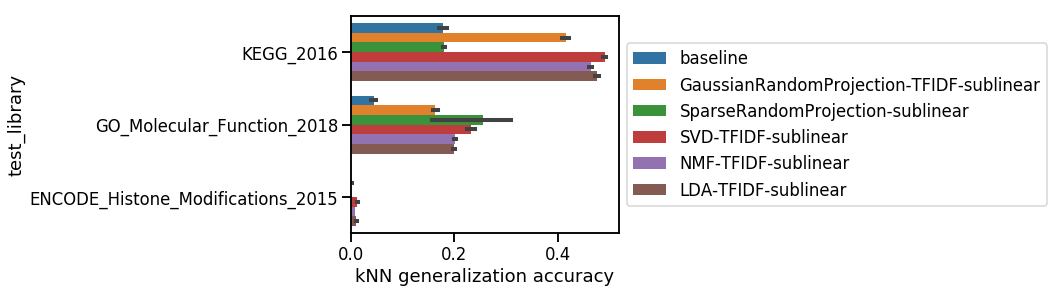

In [43]:
ax = sns.barplot(y='test_library', x='accuracy', data=knn_scores_all, hue='model')
# ax = sns.swarmplot(y='test_library', x='accuracy', data=knn_scores_all, hue='model')
ax.set_xlabel('kNN generalization accuracy')
# ax.set_xlim([-0.05, 1]);

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));